# Multi-Task Learning using Uncertainty Weighted Loss 

Multi-task learning is popular in many deep learning applications. For example, in object detection the network performs both classification and localization for each object. As a result, the final loss will be a combination of classification loss and regression loss. The most frequent way of combining two losses is by simply adding them together: 

$loss_{total} = loss_1 + loss_2$

However, a problem emerges when the two losses are on different numerical scales. To resolve this issue, people usually manually design/experimentally determine the best weight, which is very time consuming and computationally expensive:

$loss_{total} = w_1loss_1 + w_2loss_2$

[This paper](https://arxiv.org/abs/1705.07115) presents an interesting idea: make the weights w1 and w2 trainable parameters based on the uncertainty of each task, such that the network can dynamically focus more on the task with higher uncertainty.

In [1]:
import os
import tempfile

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.nn.init import kaiming_normal_ as he_normal
from torchvision import models

import fastestimator as fe
from fastestimator.backend import reduce_mean
from fastestimator.op.numpyop import Delete
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, LongestMaxSize, PadIfNeeded, ReadMat, ShiftScaleRotate
from fastestimator.op.numpyop.univariate import ChannelTranspose, Normalize, ReadImage, Reshape
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy, Dice

In [2]:
#parameters
epochs = 25
batch_size = 8
max_train_steps_per_epoch = None
max_eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()
data_dir = None

## Building Components

### Dataset

We will use the [CUB200 2010 dataset](http://www.vision.caltech.edu/visipedia/CUB-200.html) by Caltech. It contains 6033 bird images from 200 categories, where each image also has a corresponding mask. Therefore, our task is to classify and segment the bird given the image.

We use a FastEstimator API to load the CUB200 dataset and split the dataset to get train, evaluation and test sets.

In [3]:
from fastestimator.dataset.data import cub200

train_data = cub200.load_data(root_dir=data_dir)
eval_data = train_data.split(0.3)
test_data = eval_data.split(0.5) 

### Step 1: Create `Pipeline`

We read the images with `ReadImage`, and the masks stored in a MAT file with `ReadMat`. There is other information stored in the MAT file, so we specify the key `seg` to retrieve the mask only.

Here the main task is to resize the images and masks into 512 by 512 pixels. We use `LongestMaxSize` (to preserve the aspect ratio) and `PadIfNeeded` to resize the image. We will augment both image and mask in the same way and rescale the image pixel values between -1 and 1 since we are using pre-trained ImageNet weights.

In [4]:
pipeline = fe.Pipeline(batch_size=batch_size,
                       train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       ops=[
                           ReadImage(inputs="image",
                                     outputs="image",
                                     parent_path=train_data.parent_path),
                           Normalize(inputs="image",
                                     outputs="image",
                                     mean=1.0,
                                     std=1.0,
                                     max_pixel_value=127.5),
                           ReadMat(file='annotation',
                                   keys="seg",
                                   parent_path=train_data.parent_path),
                           Delete(keys="annotation"),
                           LongestMaxSize(max_size=512,
                                          image_in="image",
                                          image_out="image",
                                          mask_in="seg",
                                          mask_out="seg"),
                           PadIfNeeded(min_height=512,
                                       min_width=512,
                                       image_in="image",
                                       image_out="image",
                                       mask_in="seg",
                                       mask_out="seg",
                                       border_mode=cv2.BORDER_CONSTANT,
                                       value=0,
                                       mask_value=0),
                           ShiftScaleRotate(
                               image_in="image",
                               mask_in="seg",
                               image_out="image",
                               mask_out="seg",
                               mode="train",
                               shift_limit=0.2,
                               rotate_limit=15.0,
                               scale_limit=0.2,
                               border_mode=cv2.BORDER_CONSTANT,
                               value=0,
                               mask_value=0),
                           Sometimes(
                               HorizontalFlip(image_in="image",
                                              mask_in="seg",
                                              image_out="image",
                                              mask_out="seg",
                                              mode="train")),
                           ChannelTranspose(inputs="image",
                                            outputs="image"),
                           Reshape(shape=(1, 512, 512),
                                   inputs="seg",
                                   outputs="seg")
                       ])

### Let's visualize our `Pipeline` results

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def Minmax(data):
    data_max = np.max(data)
    data_min = np.min(data)
    data = (data - data_min) / max((data_max - data_min), 1e-7)
    return data


def visualize_image_mask(img, mask):
    img = (img*255).astype(np.uint8)
    
    mask = mask.astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    ret, mask_thres = cv2.threshold(mask, 0.5,1, cv2.THRESH_BINARY)
    mask_overlay = mask * mask_thres
    mask_overlay = np.where( mask_overlay != [0,0,0], [255,0,0] ,[0,0,0])
    mask_overlay = mask_overlay.astype(np.uint8)
    img_with_mask = cv2.addWeighted(img, 0.7, mask_overlay, 0.3,0 )

    maskgt_with_maskpred = cv2.addWeighted(mask, 0.7, mask_overlay, 0.3, 0)

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,8))
    ax[0].imshow(img)
    ax[0].set_title('original image')
    ax[1].imshow(img_with_mask)
    ax[1].set_title('img - mask overlay')
    plt.show()

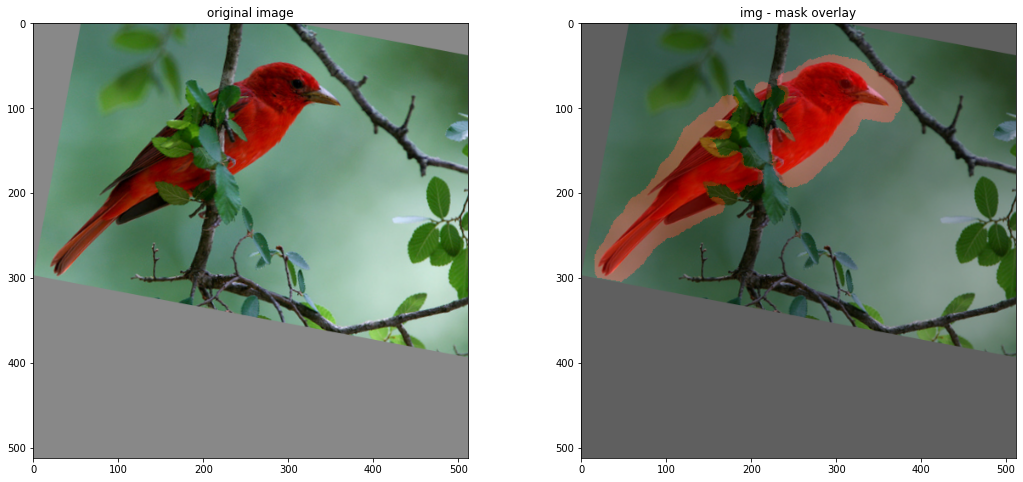

In [6]:
idx = np.random.randint(low=0, high=batch_size)
result = pipeline.get_results()
img = Minmax(result["image"][idx].numpy())
msk = np.squeeze(result["seg"][idx].numpy())
img = np.transpose(img, (1, 2, 0))

visualize_image_mask(img, msk)

### Step 2: Create `Network`
In this implementation, the network architecture is not the focus. Therefore, we are going to create something out of the blue :). How about a combination of resnet50 and Unet that can do both classification and segmentation? We can call it - ResUnet50 

In [7]:
class Upsample2D(nn.Module):
    """Upsampling Block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(mode="bilinear", scale_factor=2, align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        for l in self.upsample:
            if isinstance(l, nn.Conv2d):
                he_normal(l.weight.data)

    def forward(self, x):
        return self.upsample(x)


class DecBlock(nn.Module):
    """Decoder Block"""
    def __init__(self, upsample_in_ch, conv_in_ch, out_ch):
        super().__init__()
        self.upsample = Upsample2D(upsample_in_ch, out_ch)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(conv_in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True))

        for l in self.conv_layers:
            if isinstance(l, nn.Conv2d):
                he_normal(l.weight.data)

    def forward(self, x_up, x_down):
        x = self.upsample(x_up)
        x = torch.cat([x, x_down], 1)
        x = self.conv_layers(x)
        return x


class ResUnet50(nn.Module):
    """Network Architecture"""
    def __init__(self, num_classes=200):
        super().__init__()
        base_model = models.resnet50(pretrained=True)

        self.enc1 = nn.Sequential(*list(base_model.children())[:3])
        self.input_pool = list(base_model.children())[3]
        self.enc2 = nn.Sequential(*list(base_model.children())[4])
        self.enc3 = nn.Sequential(*list(base_model.children())[5])
        self.enc4 = nn.Sequential(*list(base_model.children())[6])
        self.enc5 = nn.Sequential(*list(base_model.children())[7])
        self.fc = nn.Linear(2048, num_classes)

        self.dec6 = DecBlock(2048, 1536, 512)
        self.dec7 = DecBlock(512, 768, 256)
        self.dec8 = DecBlock(256, 384, 128)
        self.dec9 = DecBlock(128, 128, 64)
        self.dec10 = Upsample2D(64, 2)
        self.mask = nn.Conv2d(2, 1, kernel_size=1)

    def forward(self, x):
        x_e1 = self.enc1(x)
        x_e1_1 = self.input_pool(x_e1)
        x_e2 = self.enc2(x_e1_1)
        x_e3 = self.enc3(x_e2)
        x_e4 = self.enc4(x_e3)
        x_e5 = self.enc5(x_e4)

        x_label = fn.max_pool2d(x_e5, kernel_size=x_e5.size()[2:])
        x_label = x_label.view(x_label.shape[0], -1)
        x_label = self.fc(x_label)
        x_label = torch.softmax(x_label, dim=-1)

        x_d6 = self.dec6(x_e5, x_e4)
        x_d7 = self.dec7(x_d6, x_e3)
        x_d8 = self.dec8(x_d7, x_e2)
        x_d9 = self.dec9(x_d8, x_e1)
        x_d10 = self.dec10(x_d9)
        x_mask = self.mask(x_d10)
        x_mask = torch.sigmoid(x_mask)
        return x_label, x_mask

Other than the ResUnet50, we will have another network to contain the trainable weighted parameter in the weighted loss. We call it our uncertainty model. In the network `ops`, ResUnet50 produces both a predicted label and predicted mask. These two predictions are then fed to classification loss and segmentation loss operators respectively. Finally, both losses are passed to the uncertainty model to create a final loss.

In [8]:
class UncertaintyLossNet(nn.Module):
    """Creates Uncertainty weighted loss model https://arxiv.org/abs/1705.07115
    """
    def __init__(self):
        super().__init__()
        self.w1 = nn.Parameter(torch.zeros(1))
        self.w2 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        loss = torch.exp(-self.w1) * x[0] + self.w1 + torch.exp(
            -self.w2) * x[1] + self.w2
        return loss

We also implement a `TensorOp` to average the output of `UncertaintyLossNet` for each batch:

In [9]:
class ReduceLoss(TensorOp):
    def forward(self, data, state):
        return reduce_mean(data)

In [10]:
resunet50 = fe.build(model_fn=ResUnet50,
                     model_name="resunet50",
                     optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-4))
uncertainty = fe.build(model_fn=UncertaintyLossNet,
                       model_name="uncertainty",
                       optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-5))

network = fe.Network(ops=[
    ModelOp(inputs='image',
            model=resunet50,
            outputs=["label_pred", "mask_pred"]),
    CrossEntropy(inputs=["label_pred", "label"],
                 outputs="cls_loss",
                 form="sparse",
                 average_loss=False),
    CrossEntropy(inputs=["mask_pred", "seg"],
                 outputs="seg_loss",
                 form="binary",
                 average_loss=False),
    ModelOp(inputs=["cls_loss", "seg_loss"],
            model=uncertainty,
            outputs="total_loss"),
    ReduceLoss(inputs="total_loss", outputs="total_loss"),
    UpdateOp(model=resunet50, loss_name="total_loss"),
    UpdateOp(model=uncertainty, loss_name="total_loss")
])

### Step 3: Create `Estimator`

We will have four different traces to control/monitor the training: `Dice` and `Accuracy` will be used to measure segmentation and classification results, `BestModelSaver` will save the model with best loss, and `LRScheduler` will apply a cosine learning rate decay throughout the training loop.

In [11]:
traces = [
    Accuracy(true_key="label", pred_key="label_pred"),
    Dice(true_key="seg", pred_key='mask_pred'),
    BestModelSaver(model=resunet50,
                   save_dir=save_dir,
                   metric="total_loss",
                   save_best_mode="min"),
    LRScheduler(model=resunet50,
                lr_fn=lambda step: cosine_decay(
                    step, cycle_length=13200, init_lr=1e-4))
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         traces=traces,
                         epochs=epochs,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         max_eval_steps_per_epoch=max_eval_steps_per_epoch,
                         log_steps=500)

## Training and Testing

The whole training (25 epochs) will take about 1 hour 20 mins on single V100 GPU. We are going to reach ~0.87 dice and ~83% accuracy by the end of the training.

In [12]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; resunet50_lr: 0.0001; uncertainty_lr: 1e-05; 
FastEstimator-Train: step: 1; total_loss: 8.121616; resunet50_lr: 1e-04; 
FastEstimator-Train: step: 500; total_loss: 4.7089643; steps/sec: 3.17; resunet50_lr: 9.9651326e-05; 
FastEstimator-Train: step: 528; epoch: 1; epoch_time: 167.79 sec; 
FastEstimator-ModelSaver: saved model to /tmp/tmpij3gx2qr/resunet50_best_total_loss.pt
FastEstimator-Eval: step: 528; epoch: 1; total_loss: 3.9346602; min_total_loss: 3.9346602; since_best: 0; accuracy: 0.16022099447513813; Dice: 0.7908390168

Let's load the model with best loss and check our performance on the test set:

In [13]:
fe.backend.load_model(resunet50, os.path.join(save_dir, 'resunet50_best_total_loss.pt'))
estimator.test()

Loaded model weights from /tmp/tmpij3gx2qr/resunet50_best_total_loss.pt
FastEstimator-Test: epoch: 25; accuracy: 0.8342541436464088; Dice: 0.8676798139291644; 


## Inferencing

We randomly select an image from the test dataset and use `pipeline.transform` to process the image. We generate the results using `network.transform` and visualize the prediction.

In [14]:
data = test_data[np.random.randint(low=0, high=len(test_data))]
result = pipeline.transform(data, mode="infer")

img = np.squeeze(result["image"])
img = np.transpose(img, (1, 2, 0))
mask_gt = np.squeeze(result["seg"])

### Visualize Ground Truth

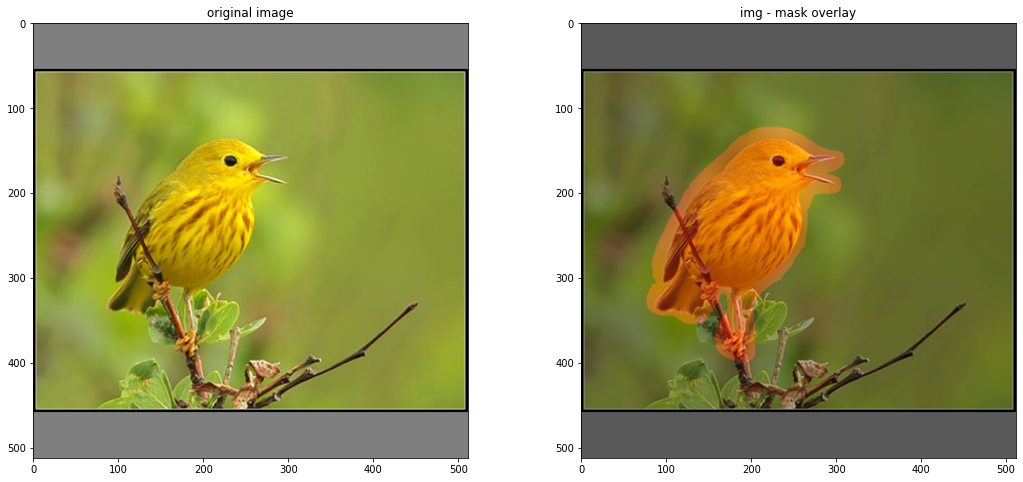

In [15]:
visualize_image_mask(Minmax(img), mask_gt)

### Visualize Prediction

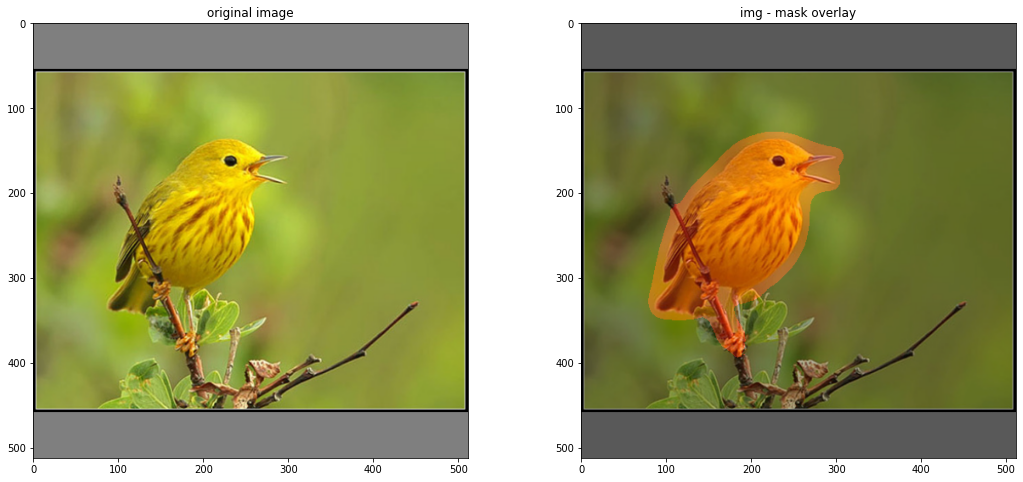

In [16]:
network = fe.Network(ops=[
    ModelOp(inputs='image', model=resunet50, outputs=["label_pred", "mask_pred"])
])

predictions = network.transform(result, mode="infer")
predicted_mask = predictions["mask_pred"].numpy() 
pred_mask = np.squeeze(predicted_mask)
pred_mask = np.round(pred_mask).astype(mask_gt.dtype)

visualize_image_mask(Minmax(img), pred_mask)